In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath
import networkx as nx

from metal.label_model import LabelModel
from metal.label_model.learn_deps import DependencyLearner

from metal.label_model.graph_utils import generate_edges
from metal.label_model.graph_utils import JunctionTree
from metal.label_model.graph_utils import DependenciesGraph
from synthetic.generate_spa import (
    ChainDependencies,
    TreeDependencies,
    ClusterDependencies,
    DataGenerator
)
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Data by Passing in Edge List

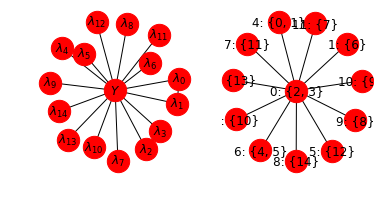

In [8]:
M = 15
N = 1000 #not used
MAX_CLIQUE_SIZE = 2
NUM_CLIQUES = 3
K = 2
HIGHER_ORDER_CLIQUES = False

# Set Graph Structure
EDGES = generate_edges(M, MAX_CLIQUE_SIZE, NUM_CLIQUES)
deps_graph = DependenciesGraph(M, EDGES)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
deps_graph.draw()


#Generate Data
data = DataGenerator(
    N,
    M,
    k=K,
    abstains=False,
    deps_graph=deps_graph,
    class_balance=0.5,
    higher_order_cliques=HIGHER_ORDER_CLIQUES
)
plt.subplot(1,2,2)
data.jt.draw()

#Generate Data
sigma_O = data.get_sigma_O()
E_O = np.array([data.P_marginal(v) for i, v in data.jt.iter_observed()])
class_balance = data.get_class_balance()
mu = data.get_mu()

## True Dependencies

In [11]:
lm_true = LabelModel(k=K)
lm_true.train(
    sigma_O=sigma_O,
    E_O=E_O,
    junction_tree=data.jt,
    abstains = False,
    lr=1e-2,
    n_epochs=10000,
    print_every=1000,
    higher_order_cliques=HIGHER_ORDER_CLIQUES
)

print ("True Mu Error: ", np.mean(np.abs(lm_true.mu - mu)))

Estimating Z...
[E:0]	Train Loss: 45.10079575
[E:1000]	Train Loss: 0.00000000
[E:2000]	Train Loss: 0.00000000
[E:3000]	Train Loss: 0.00000000
[E:4000]	Train Loss: 0.00000000
[E:5000]	Train Loss: 0.00000000
[E:6000]	Train Loss: 0.00000000
[E:7000]	Train Loss: 0.00000000
[E:8000]	Train Loss: 0.00000000
[E:9000]	Train Loss: 0.00000000
[E:9999]	Train Loss: 0.00000000
Finished Training
True Mu Error:  0.09755155290583442


##  No Dependencies

In [16]:
#Create junction tree with no dependencies between LFs
edges_ind = []
for i in range(M):
    edges_ind.append((i,M))

jt_ind = JunctionTree(
            M,
            K,
            abstains=False,
            edges=edges_ind,
            higher_order_cliques=HIGHER_ORDER_CLIQUES
        )


lm_ind = LabelModel(k=K)
lm_ind.train(
    sigma_O=sigma_O,
    E_O=E_O,
    junction_tree=jt_ind,
    abstains = False,
    lr=1e-2,
    n_epochs=10000,
    print_every=1000,
    higher_order_cliques=HIGHER_ORDER_CLIQUES
)

print ("Ind. Mu Error: ", np.mean(np.abs(lm_ind.mu - mu)))

Estimating Z...
[E:0]	Train Loss: 147.16525269
[E:1000]	Train Loss: 2.10188580
[E:2000]	Train Loss: 2.10188580
[E:3000]	Train Loss: 2.10188580
[E:4000]	Train Loss: 2.10188580
[E:5000]	Train Loss: 2.10188580
[E:6000]	Train Loss: 2.10188580
[E:7000]	Train Loss: 2.10188580
[E:8000]	Train Loss: 2.10188580
[E:9000]	Train Loss: 2.10188580
[E:9999]	Train Loss: 2.10188580
Finished Training
Ind. Mu Error:  0.102272028037236


## Dependency Learning with RPCA

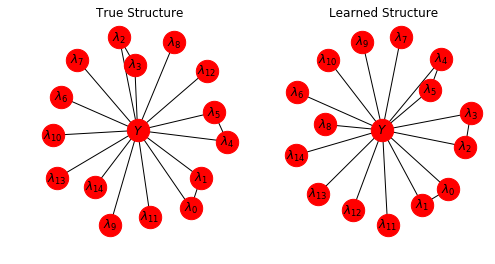

In [15]:
sig_inv = np.linalg.pinv(sigma_O)

dl = DependencyLearner(M,sig_inv)
edges_est = dl.edges_from_rpca(thresh=0.2)
deps_graph_est = DependenciesGraph(M, edges_est)


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('True Structure')
deps_graph.draw()
plt.subplot(1,2,2)
plt.title('Learned Structure')
deps_graph_est.draw()

In [18]:
for i in range(M):
        edges_est.append((i,M))

jt_est = JunctionTree(
    M,
    K,
    abstains=False,
    edges=edges_est,
    higher_order_cliques=HIGHER_ORDER_CLIQUES
)
        

lm_deps = LabelModel(k=K)
lm_deps.train(
    sigma_O=sigma_O,
    E_O=E_O,
    junction_tree=jt_est,
    abstains = False,
    lr=1e-2,
    n_epochs=10000,
    print_every=1000,
    higher_order_cliques=HIGHER_ORDER_CLIQUES
)

print ("Deps. Mu Error: ", np.mean(np.abs(lm_deps.mu - mu)))

Estimating Z...
[E:0]	Train Loss: 299.60452271
[E:1000]	Train Loss: 0.00000000
[E:2000]	Train Loss: 0.00000000
[E:3000]	Train Loss: 0.00000000
[E:4000]	Train Loss: 0.00000000
[E:5000]	Train Loss: 0.00000000
[E:6000]	Train Loss: 0.00000000
[E:7000]	Train Loss: 0.00000000
[E:8000]	Train Loss: 0.00000000
[E:9000]	Train Loss: 0.00000000
[E:9999]	Train Loss: 0.00000000
Finished Training
Deps. Mu Error:  0.09755155371084848
